In [742]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pixiedust
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [743]:
data = pd.read_csv('winemag_data_pandata.csv')

# 1. EDA

In [744]:
# data.head()

In [745]:
data['country'].value_counts()[0:3]
# Three largest are US, France, & Italy

US        54504
France    22093
Italy     19540
Name: country, dtype: int64

## Defining dataframes for each country's data:

In [746]:
# Deal with missing data
data = data.dropna(subset=['price'])

In [770]:
US_match = data['country']=='US'
US_data = data[US_match]
US_data.shape
min(US_data['price'].values)
# Some prices are less than zero. Address this ASAP.
# max(US_data['price'].values)
display(US_data)

In [ ]:
FR_match = data['country']=='France'
FR_data = data[FR_match]
FR_data.shape
min(FR_data['price'].values)
# Some prices are less than zero. Address this ASAP.
# max(FR_data['price'].values)
display(FR_data)

In [772]:
IT_match = data['country']=='Italy'
IT_data = data[IT_match]
# IT_data.head()
## So many NaNs in IT_data! Filtered them out of price, though.
min(IT_data['price'].values)
# Some prices are less than zero. Address this ASAP.
# max(IT_data['price'].values)
display(IT_data)

In [750]:
hist_data = [US_data, FR_data, IT_data]

In [ ]:
# Used pixiedust to create histograms.

In [ ]:
# First refactor: fix missing data issue
# Second refactor: plot histograms with vanilla matplotlib or seaborn

# 2. Modeling

In [751]:
# Create dataframe with price, points only
# data = pd.DataFrame(data['points'], data['price'])

In [752]:
# Deal with missing data
data = data.dropna(subset=['points'])

In [753]:
# I'll need to revisit this because the NaNs don't seem to be dropping via pandas or numpy
# in the ways that I'm attempting to drop them (both here and below)

In [754]:
data.count()

Unnamed: 0               120975
country                  120916
description              120975
designation               86196
points                   120975
price                    120975
province                 120916
region_1                 101400
region_2                  50292
taster_name               96479
taster_twitter_handle     91559
title                    120975
variety                  120974
winery                   120975
dtype: int64

In [755]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [756]:
## Linear model - points from price

In [757]:
X = data.loc[:, 'price'].values
X = X[~np.isnan(X)]
y = data.loc[:, 'points'].values

In [758]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [759]:
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [760]:
y_pred = regressor.predict(X_test.reshape(-1,1))
print(max(y_test - y_pred))

10.150010751867185


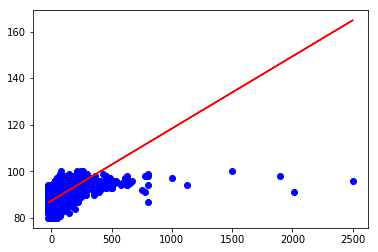

In [761]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.show()

In [762]:
## Linear model - points from log of price

In [763]:
X = data.loc[:, 'price'].values
X = X[~np.isnan(X)]
y = data.loc[:, 'points'].values
print(max(X))

3300.0


In [764]:
for i in range(len(X)):
    if X[i] > 0:
        X[i] = np.log(X[i]).astype(float)
    else:
        X[i] = 1
        # Set to a constant since failed to otherwise drop
print(max(X))

8.101677747454572


In [765]:
np.count_nonzero(np.isnan(X))

0

In [766]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [767]:
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [768]:
y_pred = regressor.predict(X_test.reshape(-1,1))
print(max(y_test - y_pred))

10.173611147550147


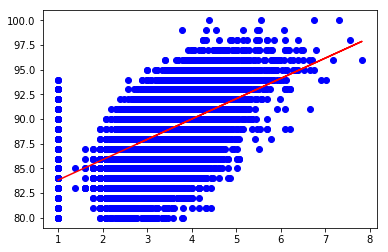

In [769]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.show()

## Note on model preference

In viewing the plots of the above models, we see that the data
in the vanilla linear model tend to fall further from the model
as the price increases, almost seeming to curve.

However, the plot of log(price) versus points fits much more naturally.
This second model still needs some work as the spread is quite wide,
but the shape of the transformed data is a much better fit for a linear model.